# Setup

In [1]:
import os
import sys
PATH_YIELD_ENGINE = os.path.join(os.getcwd(), os.pardir)
PATH_SRC = os.path.join(PATH_YIELD_ENGINE, 'src')
sys.path.append(PATH_SRC)
os.chdir(PATH_YIELD_ENGINE)

In [2]:
import logging
import os    
import re
import pprint
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from typing import *

from yieldengine import Sample
from yieldengine.dendrogram import DendrogramDrawer
from yieldengine.dendrogram.style import FeatMapStyle, LineStyle
from yieldengine.df.pipeline import PipelineDF
from yieldengine.preprocessing.encode import OneHotEncoderDF
from yieldengine.preprocessing.impute import SimpleImputerDF, MissingIndicatorDF
from yieldengine.preprocessing.selection import BorutaDF
from yieldengine.preprocessing.compose import ColumnTransformerDF
from yieldengine.model.inspection import ModelInspector
from yieldengine.model.prediction import PredictorCV
from yieldengine.model.selection import Model, ModelGrid, ModelRanker, summary_report, ModelEvaluation, ModelScoring
from yieldengine.model.validation import CircularCrossValidator

In [3]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

# Utilities

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # x-data for the ECDF: x
    x = np.sort(data[~data.isna()])

    # Number of data points: n
    n = len(x)
    
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) 

    # outliers
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    out_lower = q1 - 1.5 * iqr
    out_upper = q3 + 1.5 * iqr
    far_out_lower = q1 - 3 * iqr
    far_out_upper = q3 + 3 * iqr
    
    inlier_mask = (x >= out_lower) & (x <= out_upper)
    outlier_mask = (~inlier_mask) & (x >= far_out_lower) & (x <= far_out_upper)
    far_out_mask = ~(inlier_mask | outlier_mask) 
    
    return x[inlier_mask], y[inlier_mask], x[outlier_mask], y[outlier_mask], x[far_out_mask], y[far_out_mask]

def plot_ecdf(data: pd.Series):
    plt.plot(*ecdf(data), marker='.', linestyle='none')
    if hasattr(data, 'name'):
        plt.xlabel(data.name)
    plt.ylabel('count')

In [6]:
def remove_outliers(df: pd.DataFrame, iqr_multiple : float = 1.5) -> pd.DataFrame:
    """Replaces outliers to NaN. Based on  an IQR threshold"""
    df_numerical = df.select_dtypes(np.number)
    (_, q1), (_, q3) = df_numerical.quantile([0.25, 0.75]).iterrows()
    outlier_threshold = (q3 - q1) * iqr_multiple
    return pd.concat(
        [
            df_numerical.where(
                (df_numerical >= (q1 - outlier_threshold)) & (df_numerical <= (q3 + outlier_threshold)),
                other=np.nan,
            ),
            df.loc[:, df.columns.drop(df_numerical.columns)],
        ],
        axis=1,
    )

# Load data

## Raw data

In [7]:
DATA_DIR = os.path.join('tmp', 'ames-housing-dataset')
RAW_DATA_CSV = os.path.join(DATA_DIR, 'train.csv')
TARGET = "SalePrice"

In [8]:
print(f"Read {RAW_DATA_CSV}")
raw_df = pd.read_csv(RAW_DATA_CSV)

Read tmp\ames-housing-dataset\train.csv


## Description of the variables

In [9]:
DESCRIPTION = os.path.join(DATA_DIR, 'data_description.txt')

In [10]:
with open(DESCRIPTION, 'r') as f:
    description = f.read()

In [11]:
print(description[:1000])

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [12]:
splitted = description.split()
idx_begin = [i for i, w in enumerate(description.split()) if w.endswith(':')]
description_dict = {
       splitted[idx_begin[i]][:-1]: ' '.join(splitted[idx_begin[i]+1: idx_begin[i+1]]) for i in range(len(idx_begin)-1)
}

In [13]:
pprint.pprint(description_dict)

{'1stFlrSF': 'First Floor square feet',
 '2ndFlrSF': 'Second floor square feet',
 '3SsnPorch': 'Three season porch area in square feet',
 'Alley': 'Type of alley access to property Grvl Gravel Pave Paved NA No alley '
          'access',
 'Bedroom': 'Bedrooms above grade (does NOT include basement bedrooms)',
 'BldgType': 'Type of dwelling 1Fam Single-family Detached 2FmCon Two-family '
             'Conversion; originally built as one-family dwelling Duplx Duplex '
             'TwnhsE Townhouse End Unit TwnhsI Townhouse Inside Unit',
 'BsmtCond': 'Evaluates the general condition of the basement Ex Excellent Gd '
             'Good TA Typical - slight dampness allowed Fa Fair - dampness or '
             'some cracking or settling Po Poor - Severe cracking, settling, '
             'or wetness NA No Basement',
 'BsmtExposure': 'Refers to walkout or garden level walls Gd Good Exposure Av '
                 'Average Exposure (split levels or foyers typically score '
                 'av

 'LowQualFinSF': 'Low quality finished square feet (all floors)',
 'MSSubClass': 'Identifies the type of dwelling involved in the sale. 20 '
               '1-STORY 1946 & NEWER ALL STYLES 30 1-STORY 1945 & OLDER 40 '
               '1-STORY W/FINISHED ATTIC ALL AGES 45 1-1/2 STORY - UNFINISHED '
               'ALL AGES 50 1-1/2 STORY FINISHED ALL AGES 60 2-STORY 1946 & '
               'NEWER 70 2-STORY 1945 & OLDER 75 2-1/2 STORY ALL AGES 80 SPLIT '
               'OR MULTI-LEVEL 85 SPLIT FOYER 90 DUPLEX - ALL STYLES AND AGES '
               '120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER 150 '
               '1-1/2 STORY PUD - ALL AGES 160 2-STORY PUD - 1946 & NEWER 180 '
               'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER 190 2 FAMILY '
               'CONVERSION - ALL STYLES AND AGES',
 'MSZoning': 'Identifies the general zoning classification of the sale. A '
             'Agriculture C Commercial FV Floating Village Residential I '
             'Industrial RH Re

## EDA

In [14]:
print(f"Shape of the raw data: {raw_df.shape}")

Shape of the raw data: (1460, 81)


In [15]:
raw_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
raw_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [17]:
dt = raw_df.dtypes.rename('dtype').astype(str)
dt.groupby(by=dt.values).count().to_frame()

,dtype
float64,3
int64,35
object,43


## Sort by sold date

In [ ]:
df_tmp = raw_df.copy()

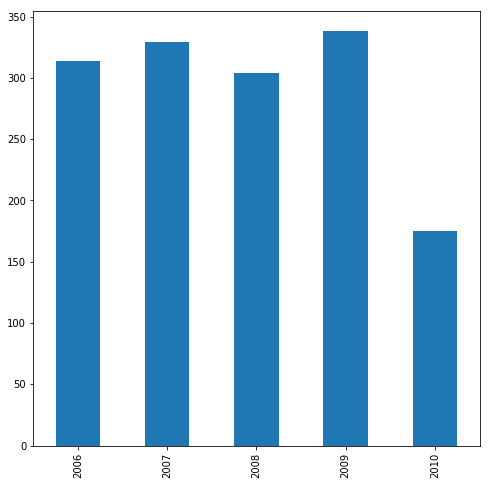

In [ ]:
df_tmp['YrSold'].value_counts().sort_index().plot(kind='bar')

In [ ]:
df_tmp['DateSold'] = pd.to_datetime(df_tmp['YrSold']*100 + df_tmp['MoSold'], format='%Y%m')

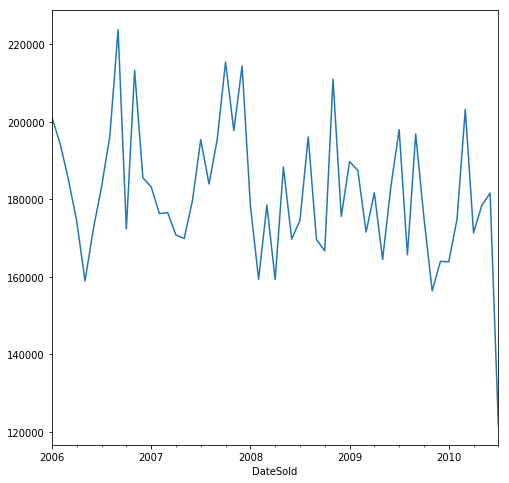

In [ ]:
df_tmp.groupby('DateSold')[TARGET].mean().plot()

In [ ]:
max_date = df_tmp['DateSold'].max()
print(max_date)
mask = df_tmp['DateSold'] == max_date
df_tmp[mask]

2010-07-01 00:00:00


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DateSold
66,67,20,RL,NaN,19900,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2010,WD,Normal,180000,2010-07-01
419,420,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2010,WD,Normal,142000,2010-07-01
705,706,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000,2010-07-01
1144,1145,190,RL,60.0,12180,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,7,2010,WD,Normal,80000,2010-07-01
1160,1161,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2010,WD,Normal,146000,2010-07-01
1421,1422,120,RL,53.0,4043,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2010,WD,Normal,127500,2010-07-01


## Data Prep

In [ ]:
dataset_df = raw_df.copy()

In [ ]:
dataset_df = dataset_df.sort_values(by=['YrSold', 'MoSold'])

In [ ]:
# Drop the Id column and date columns
dataset_df = dataset_df.drop(['Id', 'YrSold', 'MoSold'], axis=1)

In [ ]:
features_df = dataset_df.drop(columns=TARGET)

cat_features = features_df.select_dtypes(['category', object]).columns
num_features = features_df.select_dtypes('number').columns

print (f"{features_df.shape[1] - len(cat_features) - len(num_features)} not a number or category")

del features_df

0 not a number or category


In [ ]:
# remove infinity values
dataset_df = dataset_df.replace([np.inf, -np.inf], np.nan)

In [ ]:
for col_name in cat_features:
    dataset_df.loc[:, col_name] = (
        dataset_df.loc[:, col_name].astype(object).fillna('missing value').astype(str).str.strip().str.lower().astype('category')
    )

# output datasets

dt = dataset_df.dtypes.rename('dtype').astype(str)
dt.groupby(by=dt.values).count().to_frame()

,dtype
category,43
float64,3
int64,32


## Select only numerical features

In [ ]:
dataset_df = dataset_df[list(num_features) + [TARGET]]

# remove outliers (features and target)

## Remove outliers

In [ ]:
# Replace outliers by NaN
dataset_df = remove_outliers(dataset_df, iqr_multiple=3.0)

In [ ]:
# Filter the rows of the dataset where the target is not NaN
mask = dataset_df.loc[:, TARGET].notna()
dataset_df = dataset_df.loc[mask, :]

## Create Sample object to be used by our model

In [ ]:
# Define a Sample object to be used by our model
sample_full = Sample(
    observations=dataset_df,
    target_name=TARGET)

In [ ]:
# Print statistics of the target
print(
    f"{TARGET}: µ={sample_full.target.mean():.3g}, "
    f"σ={sample_full.target.std():.3g}={100 * sample_full.target.std() / sample_full.target.mean():.3g}%")

SalePrice: µ=1.78e+05, σ=7.07e+04=39.8%


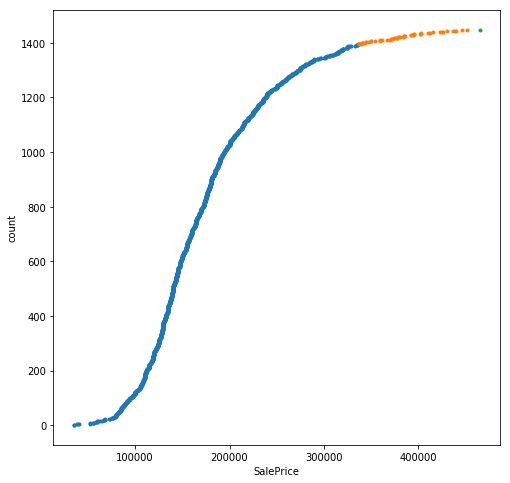

In [ ]:
plot_ecdf(sample_full.target)

## imputation and encoding

In [ ]:
def make_preprocessor(sample: Sample, onehot: bool = True, missing: bool = True):

    tx = []
    
    # define how features should be preprocessed
    tx.append((
        "impute", 
        SimpleImputerDF(strategy="median"), 
        sample.features_by_type(Sample.DTYPE_NUMERICAL).columns,
    ))

    if missing:
        tx.append((
            "missing", 
            MissingIndicatorDF(error_on_new=False), 
            sample.features_by_type(Sample.DTYPE_NUMERICAL).columns,
        ))
        
    if onehot:
        tx.append((
            "onehot", 
            OneHotEncoderDF(sparse=False, handle_unknown="ignore"),
            sample.features_by_type([Sample.DTYPE_CATEGORICAL]).columns,
        )) 
    

    return ColumnTransformerDF(
        transformers=tx
    )

## Feature selection (Boruta)

In [ ]:
preprocessor = make_preprocessor(sample=sample_full, missing=True, onehot=True)

In [ ]:
boruta_selector = PipelineDF(
    steps = [
        ('preprocess', preprocessor),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(
                    max_depth=5, #max(3, min(7, int(np.log2(len(sample_full))) - 1)),
                    min_samples_leaf=8,
                    random_state=42,
                    n_jobs=-3
                ),
                n_estimators=500,
                verbose=2,
                max_iter=100,
                random_state=42
            )
        )
    ]
)

In [ ]:
with np.errstate(invalid='ignore'):
    boruta_selector.fit(sample_full.features, sample_full.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	10
Rejected: 	32
Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	10
Rejected: 	32
Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	10
Rejected: 	32
Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	10
Rejected: 	32
Iteration: 	12 / 100
Confirmed: 	18
Tentative: 	7
Rejected: 	32
Iteration: 	13 / 100
Confirmed: 	18
Tentative: 	7
Rejected: 	32
Iteration: 	14 / 100
Confirmed: 	18
Tentative: 	7
Rejected: 	32
Iteration: 	15 / 100
Confirmed: 	18
Tentative: 	7
Rejected: 	32
Iteration: 	16 / 100
Confirmed: 	18
Tentative: 	7
Re

In [ ]:
selected = sorted(list(set(boruta_selector.columns_original)))
print(list(selected))

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']


In [ ]:
# DOES NOT WORK ???
#boruta_selector.named_steps

In [ ]:
# if selected is None:
#     raise NotImplementedError("You need to specify a backup set of variables")

# for feature in sorted(selected):
#     print(f'        "{feature}",')

In [ ]:
sample = sample_full.select_features(selected)

In [ ]:
sample.features.shape

(1448, 20)

In [ ]:
sample.features.head()

,1stFlrSF,2ndFlrSF,BsmtFinSF1,BsmtUnfSF,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,KitchenAbvGr,LotArea,LotFrontage,MasVnrArea,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
141,1734.0,0,1300.0,434,0,2,660.0,2,2005.0,1734.0,1.0,11645.0,78.0,0.0,5.0,7,1734.0,160.0,2005,2005
169,1707.0,0,0.0,1686,1,2,511.0,2,1981.0,1707.0,1.0,16669.0,NaN,653.0,6.0,8,1686.0,574.0,1981,1981
302,1541.0,0,0.0,1541,1,2,843.0,3,2001.0,1541.0,1.0,13704.0,118.0,150.0,5.0,7,1541.0,468.0,2001,2002
370,953.0,711,0.0,953,1,2,460.0,2,2000.0,1664.0,1.0,8121.0,NaN,0.0,5.0,6,953.0,100.0,2000,2000
411,1056.0,0,1056.0,0,0,1,572.0,2,1955.0,1056.0,1.0,NaN,100.0,0.0,5.0,5,1056.0,264.0,1955,1955


## Data Visualization of numerical features and categorical features

1stFlrSF
First Floor square feet


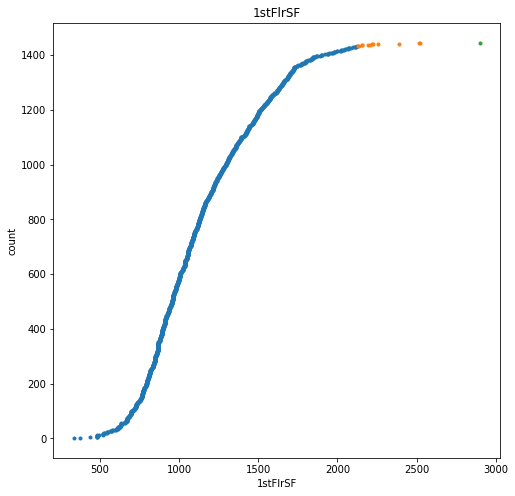

2ndFlrSF
Second floor square feet


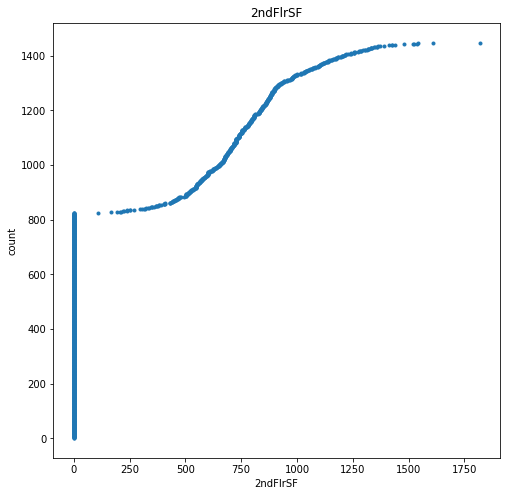

BsmtFinSF1
Type 1 finished square feet


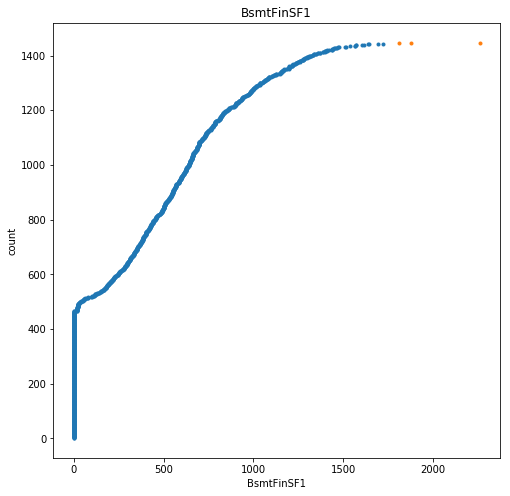

BsmtUnfSF
Unfinished square feet of basement area


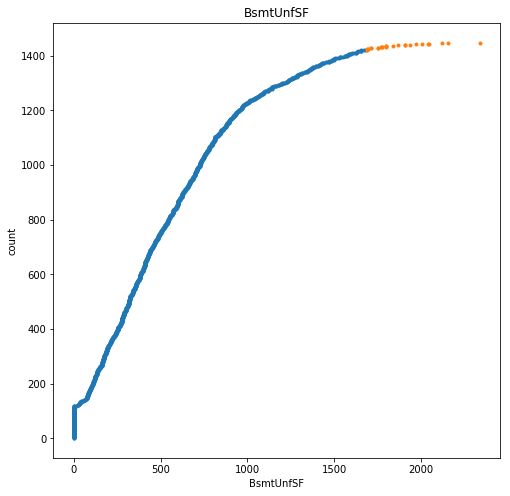

Fireplaces
Number of fireplaces


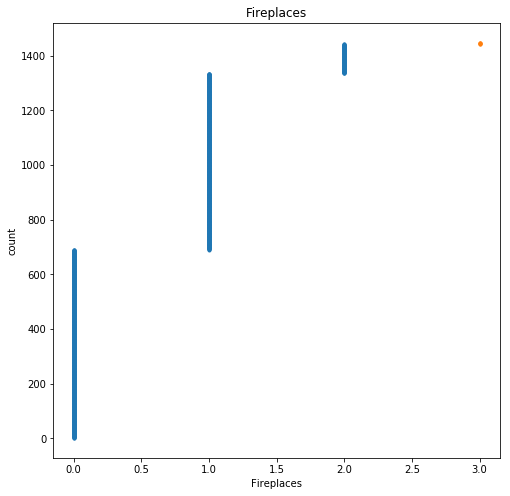

FullBath
Full bathrooms above grade


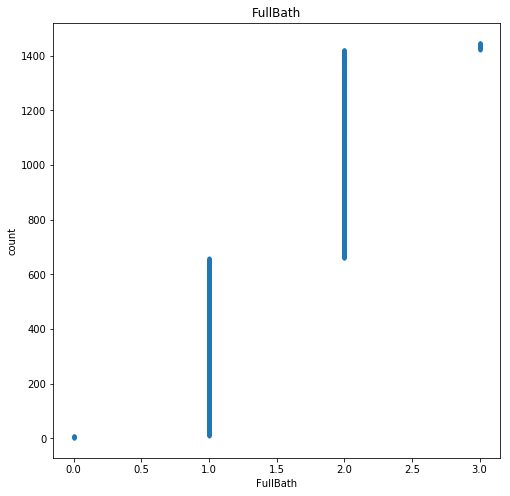

GarageArea
Size of garage in square feet


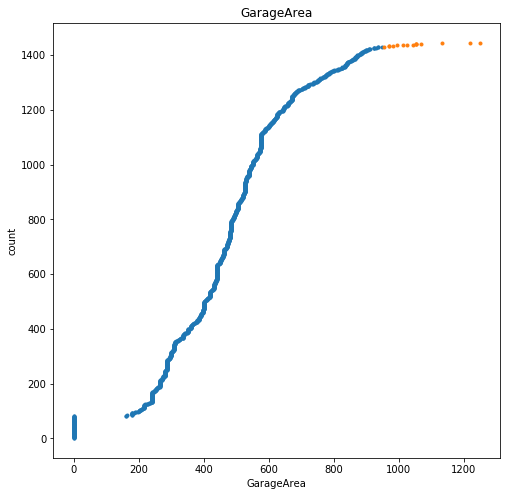

GarageCars
Size of garage in car capacity


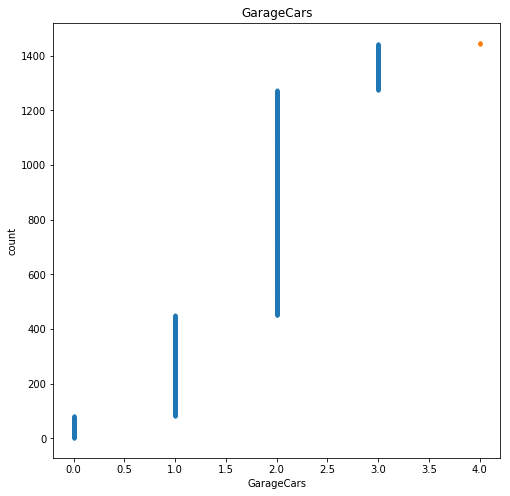

GarageYrBlt
Year garage was built


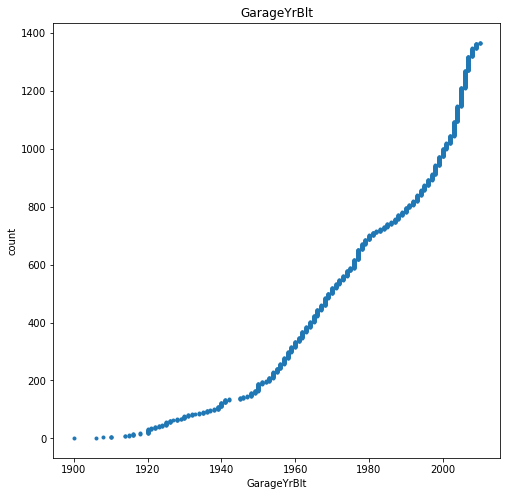

GrLivArea
Above grade (ground) living area square feet


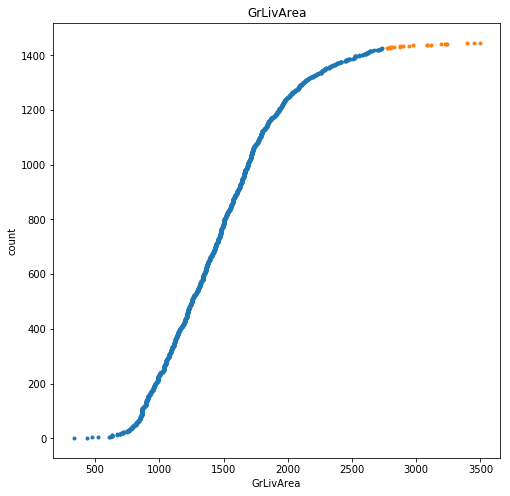

KitchenAbvGr
Missing description for KitchenAbvGr


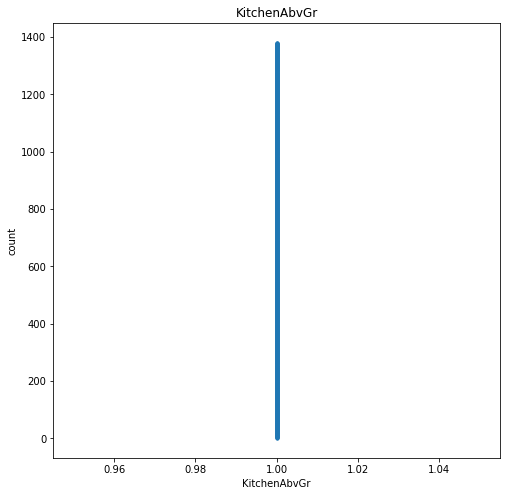

LotArea
Lot size in square feet


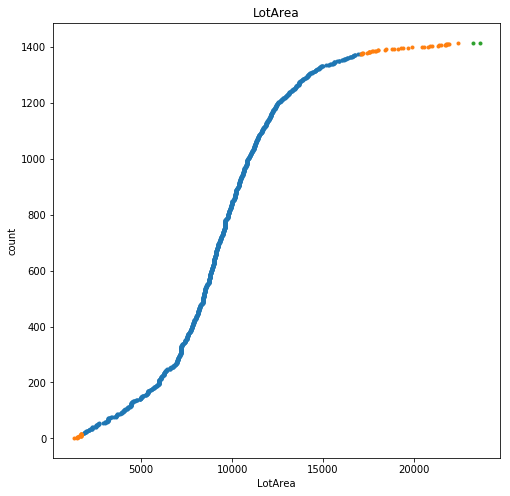

LotFrontage
Linear feet of street connected to property


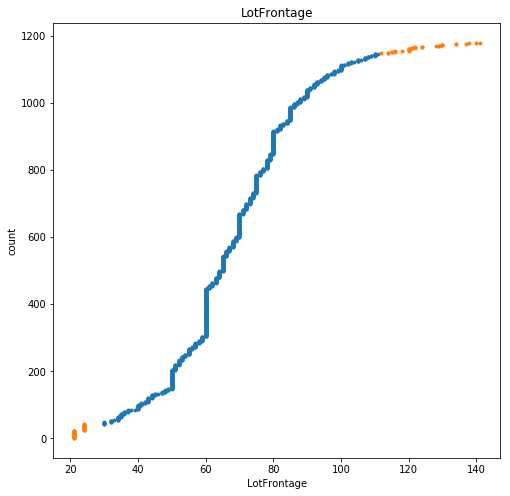

MasVnrArea
Masonry veneer area in square feet


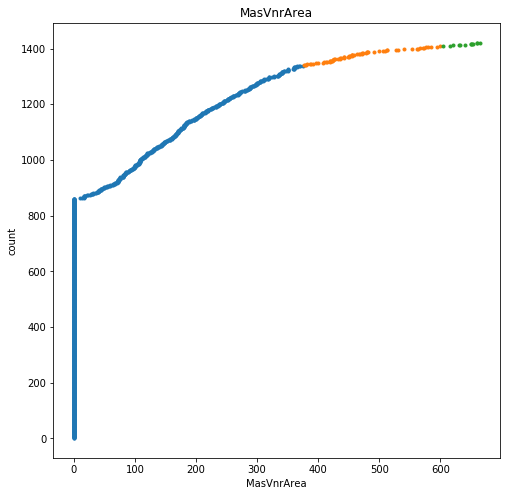

OverallCond
Rates the overall condition of the house 10 Very Excellent 9 Excellent 8 Very Good 7 Good 6 Above Average 5 Average 4 Below Average 3 Fair 2 Poor 1 Very Poor


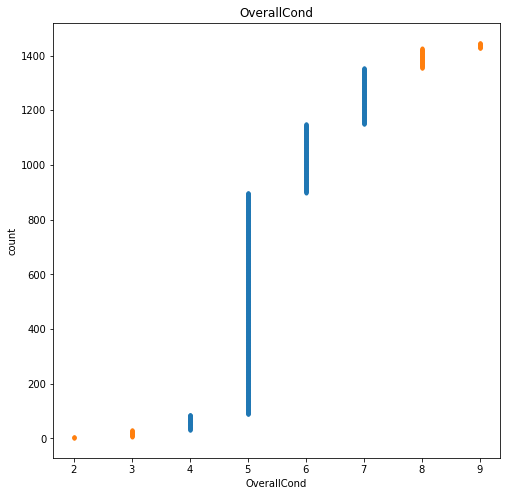

OverallQual
Rates the overall material and finish of the house 10 Very Excellent 9 Excellent 8 Very Good 7 Good 6 Above Average 5 Average 4 Below Average 3 Fair 2 Poor 1 Very Poor


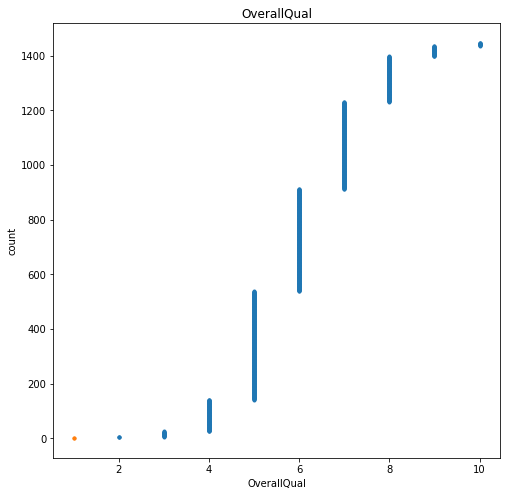

TotalBsmtSF
Total square feet of basement area


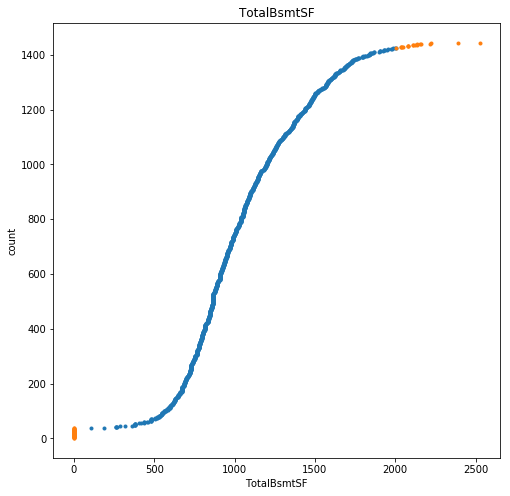

WoodDeckSF
Wood deck area in square feet


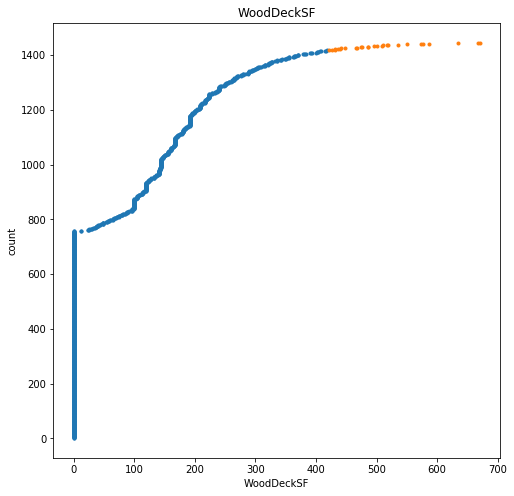

YearBuilt
Original construction date


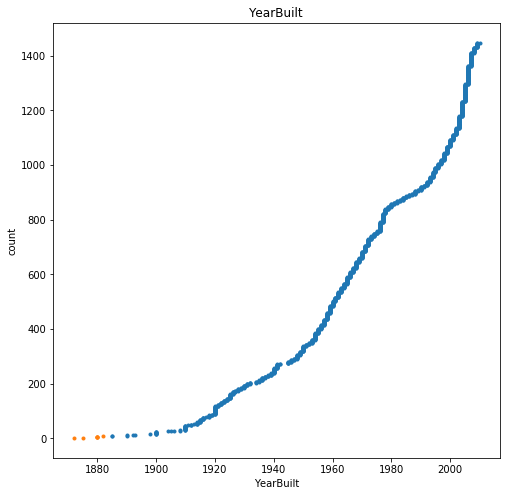

YearRemodAdd
Remodel date (same as construction date if no remodeling or additions)


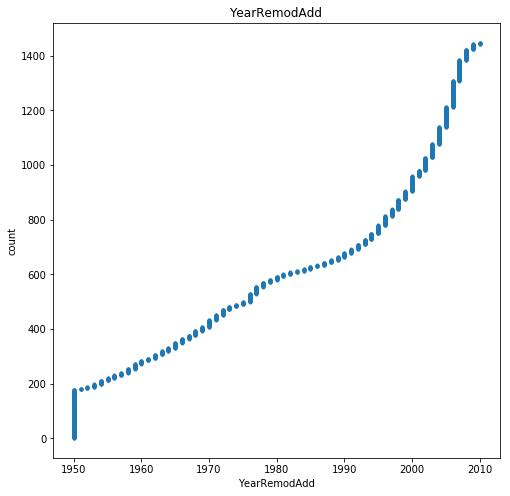

In [ ]:
ddf = sample.features_by_type(sample.DTYPE_NUMERICAL)
numerical_features_names = ddf.columns.values[:20]

for feature in numerical_features_names:
    print(feature)
    print(description_dict.get(feature, f"Missing description for {feature}"))
    plot_ecdf(ddf.loc[:, feature])
    plt.title(feature)
    plt.show()

In [ ]:
ddf = sample.features_by_type(sample.DTYPE_CATEGORICAL)
categorical_features_names = ddf.columns.values[:20]

for feature in categorical_features_names:
    print(feature)
    print(description_dict.get(feature, f"Missing description for {feature}"))
    ddf.loc[:, feature].value_counts().plot(kind='bar')
    plt.title(feature)
    plt.show()

# Model training

## Define cross validator

In [ ]:
# define the circular cross validator with 30 folds
circular_cv = CircularCrossValidator(test_ratio=1/3, num_splits=3)

## Grid search

In [ ]:
grids = [
    ModelGrid(
        model=Model(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [500],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
#     ModelGrid(
#         model=Model(
#                 estimator=Ridge(),
#                 preprocessing=make_preprocessor(sample=sample, missing=False),
#                 ),
#         estimator_parameters={
#             "alpha": [0.01, 1, 100]
#         })
]
print(f"{len(grids)} model grid(s)")

1 model grid(s)


In [ ]:
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
    #scoring='neg_mean_absolute_error'
)
ranker

In [ ]:
ranking = ranker.run(sample, n_jobs=-3)

In [ ]:
print(summary_report(ranking))

Rank  1: RandomForestRegressor, Score=    0.853, test_score_mean=    0.858, test_score_std=  0.00227, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estimators=500}

Rank  2: RandomForestRegressor, Score=    0.846, test_score_mean=    0.856, test_score_std=  0.00476, , Parameters={estimator__criterion=mse,estimator__max_depth=6,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estimators=500}

Rank  3: RandomForestRegressor, Score=    0.839, test_score_mean=    0.846, test_score_std=  0.00371, , Parameters={estimator__criterion=mse,estimator__max_depth=5,estimator__max_features=0.4,estimator__min_samples_leaf=4,estimator__n_estimators=500}

Rank  4: RandomForestRegressor, Score=    0.836, test_score_mean=    0.844, test_score_std=  0.00374, , Parameters={estimator__criterion=mse,estimator__max_depth=5,estimator__max_features=0.7,estimator__min_samples_leaf=4,estimator__n_estimator

In [ ]:
top_model = ranking[0]
top_model.scoring['test_score']

In [ ]:
top_model.parameters

{'estimator__criterion': 'mse',
 'estimator__max_depth': 6,
 'estimator__max_features': 0.4,
 'estimator__min_samples_leaf': 4,
 'estimator__n_estimators': 500}

median score: 0.86; mean score: 0.86


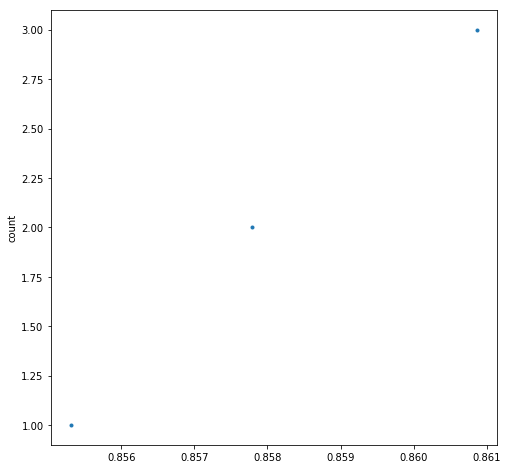

In [ ]:
top_model_scores = top_model.scoring['test_score'].split_scores
plot_ecdf(pd.Series(top_model_scores))
print(f"median score: {np.median(top_model_scores):.2g}; mean score: {np.mean(top_model_scores):.2g}")

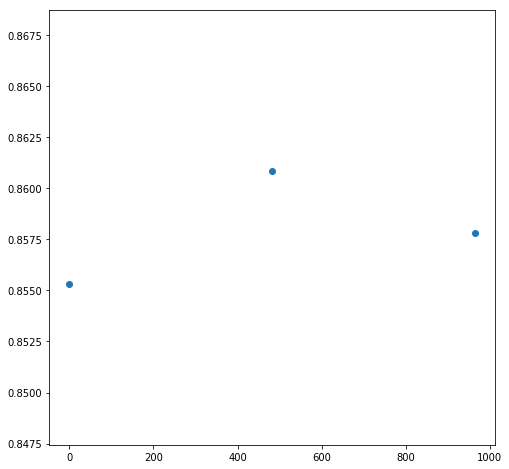

In [ ]:
# plot test folds against test scores
plt.scatter(x=list(circular_cv.test_split_starts(sample.features)), y=top_model_scores)

In [ ]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample)

In [ ]:
inspector = ModelInspector(predictor)

In [ ]:
#DOES  WORK (a bit slow)
# WHY IS IT SO SLOW?
predictions = predictor.predictions_for_all_samples()

In [ ]:
predictions.shape

(1449, 3)

In [ ]:
sample.target.shape

(1448,)

In [ ]:
predictions.head()

,split_id,prediction,target
0,2,198017.539237,208500.0
1,0,168190.198360,181500.0
2,2,207931.508956,223500.0
3,0,190454.433304,140000.0
4,2,307133.528701,250000.0


Text(0, 0.5, 'predicted')

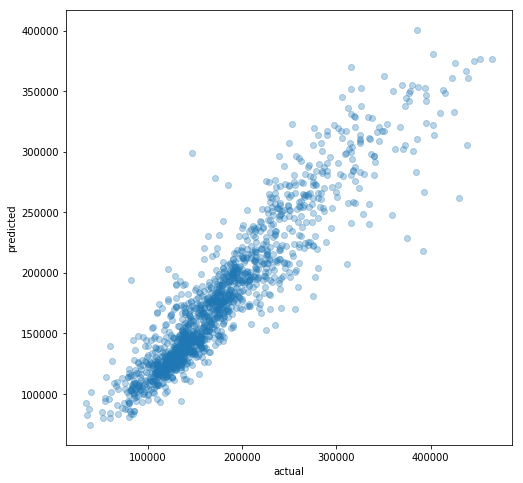

In [ ]:
plt.scatter(
    sample.target.sort_index(),
    predictions.groupby(predictions.index)['prediction'].mean().sort_index(),
    alpha=.3
)
plt.xlabel('actual')
plt.ylabel('predicted')

In [ ]:
predictions.index.values.shape

(1449,)

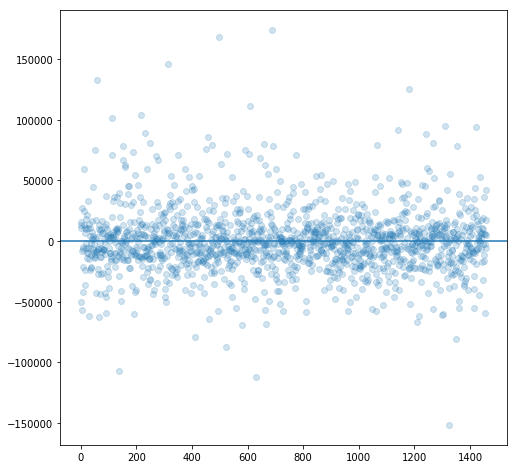

In [ ]:
predictions['error'] = (predictions['target'] - predictions['prediction'])#.abs()
plt.scatter(x=predictions.index.values, y=predictions['error'].values, alpha=.2)
plt.axhline(0)

In [ ]:
mae_model = mean_absolute_error(y_pred=predictions.prediction, y_true=predictions.target)
mae_naive = mean_absolute_error(y_pred=[predictions.target.mean()]* len(predictions), y_true=predictions.target)

print(f"MAE_relative={mae_model / mae_naive * 100:1000.3g}%, MAE_model={mae_model:.3g}, MAE_naïve={mae_naive:.3g}")

MAE_relative=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
top_model.model._estimator

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=0.4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
M = inspector.shap_matrix()

In [ ]:
M.shape

(1448, 20)

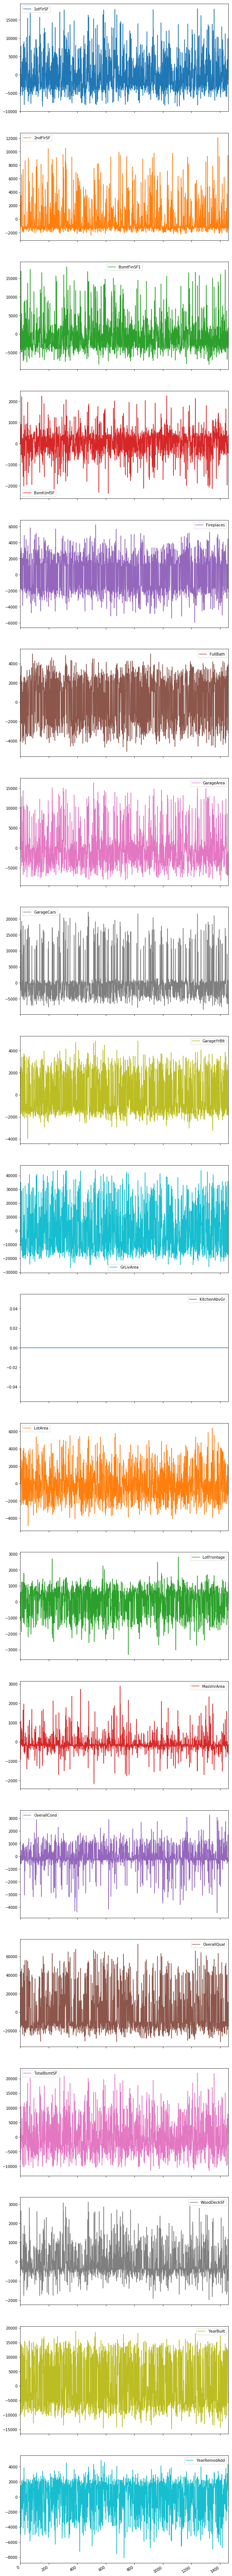

In [ ]:
number_features = predictor.sample.features.shape[1]
_ = M.plot(subplots=True, figsize=(10, number_features*7))

In [ ]:
inspector.shap_matrix().head().T

,0,1,2,3,4
column,,,,,
1stFlrSF,-3935.693065,1904.161220,-3500.164716,-5724.525417,-2848.314478
2ndFlrSF,1543.018843,-1438.858037,1359.871975,-789.533507,3568.904078
BsmtFinSF1,-234.207583,3873.021481,-1945.158411,-4124.679926,-1629.112455
BsmtUnfSF,445.528687,387.518882,275.624798,-34.214583,747.942115
Fireplaces,-1366.001638,2957.544240,1098.135234,2079.874029,1428.070416
FullBath,2658.530453,1498.583231,2433.185682,-1354.538837,2713.616378
GarageArea,798.893882,429.260584,3218.423979,901.265242,10277.710115
GarageCars,-1000.008706,225.923430,-1143.398421,16592.094243,15883.476025
GarageYrBlt,2081.598708,-1812.744835,1866.481035,1796.956197,2497.486582


In [ ]:
# _ = inspector.shap_matrix().plot(subplots=True, figsize=(10, 30))
# inspector.shap_matrix().head().T

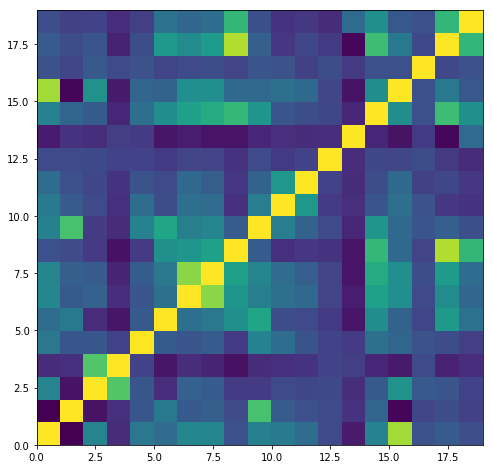

In [ ]:
depm = inspector.feature_dependency_matrix()
plt.pcolormesh(depm)

In [ ]:
inspector.feature_importances().sort_values(ascending=False).to_frame()

,0
column,
OverallQual,0.257147
GrLivArea,0.186653
YearBuilt,0.106305
TotalBsmtSF,0.066750
1stFlrSF,0.052268
GarageCars,0.048699
GarageArea,0.047706
BsmtFinSF1,0.043964
FullBath,0.031142


In [ ]:
linkage_tree = inspector.cluster_dependent_features()

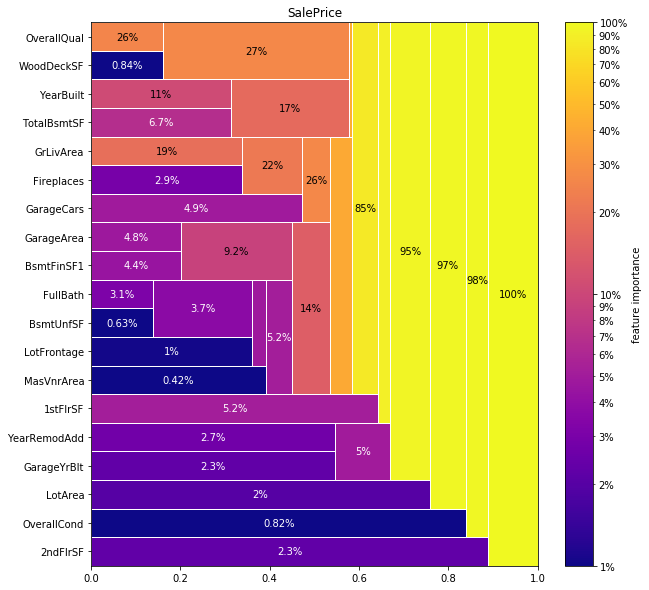

In [ ]:
#ax = plt.figure(dpi=150).add_subplot(111)
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

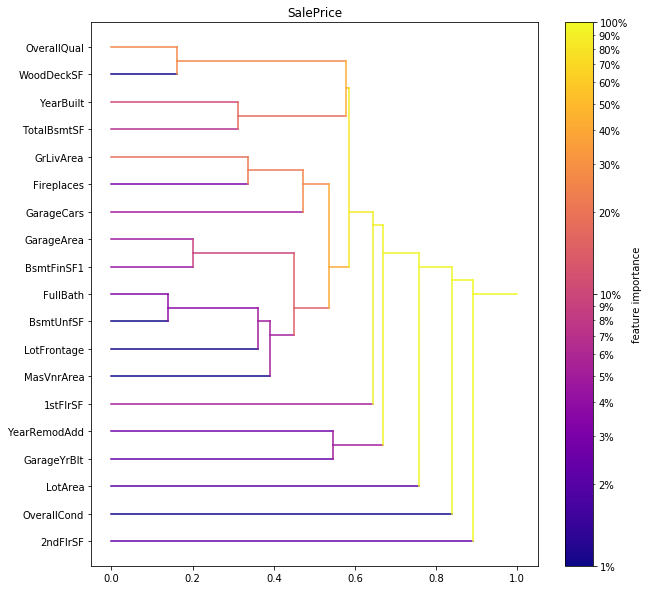

In [ ]:
ax = plt.figure(figsize=(10,number_features*0.5)).add_subplot(111)
style = LineStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

# Shap clustering iteration 1

In [ ]:
features1 = sample.feature_names

In [ ]:
black_list1 = ['WoodDeckSF', 'BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea','LotFrontage']

In [ ]:
assert set(black_list1) <= features1

In [ ]:
white_list1 = sorted(list(set(features1) - set(black_list1)))

In [ ]:
white_list1

['1stFlrSF',
 '2ndFlrSF',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenAbvGr',
 'LotArea',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [ ]:
sample1 = sample.select_features(white_list1)

## Re-run the pipeline

In [ ]:
preprocessor = make_preprocessor(sample=sample1, missing=True, onehot=True)
boruta_selector = PipelineDF(
    steps = [
        ('preprocess', preprocessor),
        (
            'boruta', 
            BorutaDF(
                estimator=RandomForestRegressor(
                    max_depth=5, #max(3, min(7, int(np.log2(len(sample_full))) - 1)),
                    min_samples_leaf=8,
                    random_state=42,
                    n_jobs=-3
                ),
                n_estimators=500,
                verbose=2,
                max_iter=100,
                random_state=42
            )
        )
    ]
)
with np.errstate(invalid='ignore'):
    boruta_selector.fit(sample1.features, sample1.target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	8


In [ ]:
selected1 = sorted(list(set(boruta_selector.columns_original)))
print(list(selected1))
sample1 = sample1.select_features(selected1)

In [ ]:
grids = [
    ModelGrid(
        model=Model(
            estimator=RandomForestRegressor(random_state=42),
            preprocessing=make_preprocessor(sample=sample1, missing=False)
        ),
        estimator_parameters = {
            "n_estimators": [500],
            "max_depth": [4,5,6],
            "min_samples_leaf": [4],
            "criterion": ["mse"], #["mae","mse"],
            "max_features": [0.4, 0.7, 1.0],
        },
    ),
]
ranker = ModelRanker(
    grids=grids,
    cv=circular_cv,
    #scoring='neg_mean_absolute_error'
)
ranking = ranker.run(sample1, n_jobs=-3)

In [ ]:
print(summary_report(ranking))

In [ ]:
top_model = ranking[0]
print(f"top_model score: {top_model.scoring['test_score']}")

In [ ]:
print(top_model.parameters)

In [ ]:
predictor = PredictorCV(model=top_model.model, cv=circular_cv, sample=sample)
inspector = ModelInspector(predictor)
M = inspector.shap_matrix()

In [ ]:
linkage_tree = inspector.cluster_dependent_features()
#ax = plt.figure(dpi=150).add_subplot(111)
ax = plt.figure(figsize=(10,number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()